[Inhaltsverzeichnis](../AP4.ipynb) | [ < zurück ](wohin?)|  [ > next](wohin?)

## 4.3.1  Szenarien stündlich aufgelöst




FLUCCOplus Setup

In [179]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [181]:
%matplotlib inline
from FLUCCOplus.notebooks import *


### Scenario Überblick
Zuerst werden alle Szenarien aus Excel eingelesen und dargestellt

In [182]:
import FLUCCOplus.scenarios as scens

In [275]:
sc = scens.all()
print(*[i+k for i,k in zip([i for i in sc.index], ["\n"]*len(sc.index))])

EM2018
 EM2019
 E-Control 2019
 Energie und Klimazukunft 2030 (Veigl17)
 Erneuerbare Energie 2030 (UBA16)
 WEM 2030 (UBA17)
 Transition 2030 (UBA17)
 Energie und Klimazukunft 2050 (Veigl17)
 Erneuerbare Energie 2050 (UBA16)
 WEM 2050 (UBA17)
 Transition 2050 (UBA17)
 100% Erneuerbare Deckung 2050 (FLUCCO+)
 100% Erneuerbare Deckung 2050 inkl Methan (FLUCCO+)



## Creating a Scenario object



In [258]:
from FLUCCOplus.scenarios import Scenario
 

### EM Base data
Select an electricity map year


In [330]:
em_year = 2018 # 2015, 2016, 2017, 2018

Select an available Scenario ``name`` 

In [326]:
#name = "EM2018"                                                  
#name = "EM2019"                                                  
#name = "E-Control 2019"                                          
#name = "Energie und Klimazukunft 2030 (Veigl17)"                 
#name = "Erneuerbare Energie 2030 (UBA16)"                        
#name = "WEM 2030 (UBA17)"                                        
#name = "Transition 2030 (UBA17)"                                 
#name = "Energie und Klimazukunft 2050 (Veigl17)"                
#name = "Erneuerbare Energie 2050 (UBA16)"                        
#name = "WEM 2050 (UBA17)"                                       
name = "Transition 2050 (UBA17)"                                 
#name = "100% Erneuerbare Deckung 2050 (FLUCCO+)"                 
#name = "100% Erneuerbare Deckung 2050 inkl Methan (FLUCCO+)" 

Create the scenario

In [331]:
import FLUCCOplus.electricitymap as elmap
s = Scenario(  
    name = name, # can be anything
    scenario = name, # must be a scenario name
    em_base = {"year": em_year,
               "df": elmap.fetch(year=em_year)})
s

C:\Users\Simon Schneider\anaconda\envs\FLUCCOplus\lib\site-packages\openpyxl\worksheet\_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\Simon Schneider\anaconda\envs\FLUCCOplus\lib\site-packages\openpyxl\worksheet\_reader.py:308: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


Transition 2050 (UBA17)

Szenario                target          base      scale
Jahr               2050.000000   2018.000000        NaN
Strombedarf      115805.564820  63497.589935   1.823779
Mismatch              0.000000           NaN        NaN
Importe               0.000000           NaN        NaN
Stromproduktion  115805.564820           NaN        NaN
Wasserkraft       47005.003760           NaN        NaN
Pumpspeicher      15041.601203   4101.638049   3.667218
Laufkraft         31963.402557  30013.912729   1.064953
Windkraft         28350.002268   6396.599663   4.432043
Photovoltaik      26456.668783   1420.744677  18.621691
Volatile EE       86770.073608           NaN        NaN
Nicht-Volatile    29035.491212           NaN        NaN
RES0              29035.491212           NaN        NaN
RES1              13993.890008           NaN        NaN
RES2             -15041.601203           NaN        NaN

In [ ]:
s.plot()

<AxesSubplot:xlabel='datetime'>

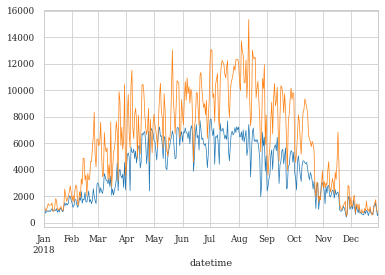

In [195]:
# get solar
pv_prod = elmap.get(year=2018,
               column="power_production_solar_avg",
               set_name="PV [MW]")

pv_cons = elmap.get(year=2018,
               column="power_consumption_solar_avg",
               set_name="PV [MW]")
pv_prod.resample("D").sum().plot()
pv_cons.resample("D").sum().plot()

(425112.0, 425256.0)

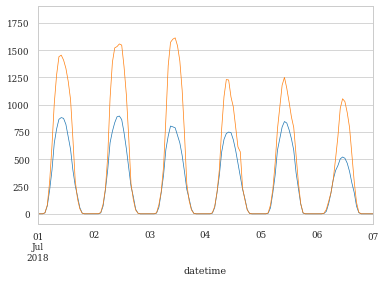

In [196]:
fig, ax = plt.subplots(1,1)
pv_prod.plot(ax=ax)
pv_cons.plot(ax=ax)
ax.set_xlim("07-01-2018", "07-07-2018")

In [197]:
# apply transform
import FLUCCOplus.transform as traffo



In [198]:
# scale to fit targetsum

# get load
# apply transform
#     ecars (non dsm)
#
# scale to fit targetsum

# em scenario residual load report
